In [1]:
!pip install onnxmltools
!pip install skl2onnx
!pip install onnxruntime

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import onnxmltools, onnxruntime as ort
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, RobustScaler
import json, hashlib, datetime
import matplotlib.pyplot as plt
import seaborn as sns

models_dir = Path("/home/ashwinvel2000/TAQA/models_3")
healthy_df = pd.read_parquet("/home/ashwinvel2000/TAQA/training_data/wide36_tools_flat.parquet")
print("rows for ML:", len(healthy_df))

rows for ML: 1288266


=== CHOKE FEATURES ANALYSIS ===

Choke-Position:
  Range: -1.892 to 102.865
  Mean±Std: 67.548 ± 47.117
  Quantiles: {0.01: -1.189178, 0.05: -0.8648529, 0.95: 101.0811, 0.99: 101.1892}

ToolStateNum:
  Range: 0.000 to 7680.000
  Mean±Std: 2.900 ± 7.115
  Range: 0.000 to 7680.000
  Mean±Std: 2.900 ± 7.115
  Quantiles: {0.01: 0.0, 0.05: 0.0, 0.95: 6.0, 0.99: 10.0}
  Value counts (top 10):
ToolStateNum
2.0     727706
6.0     255056
0.0     118002
1.0      84726
5.0      41646
3.0      14498
10.0     14113
7.0       9361
9.0       8686
8.0       5028
Name: count, dtype: int64

Downstream-Temperature:
  Range: 7.411 to 108.216
  Mean±Std: 23.531 ± 22.892
  Quantiles: {0.01: 12.80093, 0.05: 13.41162, 0.95: 96.8151175, 0.99: 108.0884}
  Quantiles: {0.01: 0.0, 0.05: 0.0, 0.95: 6.0, 0.99: 10.0}
  Value counts (top 10):
ToolStateNum
2.0     727706
6.0     255056
0.0     118002
1.0      84726
5.0      41646
3.0      14498
10.0     14113
7.0       9361
9.0       8686
8.0       5028
Name: count, dt

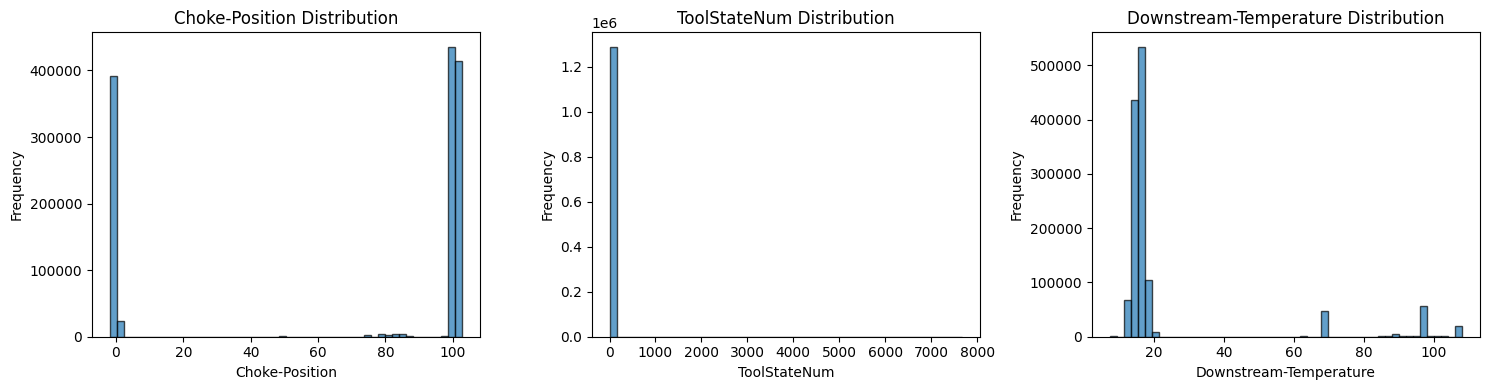

In [3]:
# Feature definitions
IF_CHOKE_FEATS = ["Choke-Position", "ToolStateNum", "Downstream-Temperature"]

# Analyze the distribution of choke features to understand the data better
print("=== CHOKE FEATURES ANALYSIS ===")
for col in IF_CHOKE_FEATS:
    print(f"\n{col}:")
    print(f"  Range: {healthy_df[col].min():.3f} to {healthy_df[col].max():.3f}")
    print(f"  Mean±Std: {healthy_df[col].mean():.3f} ± {healthy_df[col].std():.3f}")
    print(f"  Quantiles: {healthy_df[col].quantile([0.01, 0.05, 0.95, 0.99]).to_dict()}")
    if col == "ToolStateNum":
        print(f"  Value counts (top 10):\n{healthy_df[col].value_counts().head(10)}")

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(IF_CHOKE_FEATS):
    axes[i].hist(healthy_df[col], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [4]:
def export_improved_if(df_sub, cols, onnx_path, cont=0.01, scale_method='robust', 
                      n_estimators=300, max_samples=0.8, max_features=1.0):
    """
    Enhanced Isolation Forest export with preprocessing and tuning.
    
    Args:
        scale_method: 'robust', 'standard', or 'none'
        n_estimators: More trees for better performance (default 300 vs 200)
        max_samples: Subsample ratio for each tree (0.8 vs default 'auto')
        max_features: Feature subsample ratio (1.0 = use all features)
    """
    print(f"Training improved IF for {onnx_path.name} with {scale_method} scaling...")
    
    # Get raw features
    X_raw = df_sub[cols].astype(np.float32).values
    print(f"  Raw data shape: {X_raw.shape}")
    
    # Apply scaling if requested
    if scale_method == 'robust':
        scaler = RobustScaler()
        X = scaler.fit_transform(X_raw).astype(np.float32)
        print(f"  Applied RobustScaler (median centering, IQR scaling)")
    elif scale_method == 'standard':
        scaler = StandardScaler()
        X = scaler.fit_transform(X_raw).astype(np.float32)
        print(f"  Applied StandardScaler (z-score normalization)")
    else:
        X = X_raw
        scaler = None
        print(f"  No scaling applied")
    
    # Train model with improved hyperparameters
    model = IsolationForest(
        n_estimators=n_estimators,      # More trees
        contamination=cont,
        max_samples=max_samples,        # Subsample for diversity
        max_features=max_features,      # Feature bagging
        random_state=42
    ).fit(X)
    
    print(f"  Model trained with contamination={cont}")
    
    # Convert to ONNX (using same simple approach as baseline)
    print(f"  Converting to ONNX...")
    initial_type = [('input', FloatTensorType([None, X.shape[1]]))]
    onnx_model = convert_sklearn(model, initial_types=initial_type,
                               target_opset={'': 12, 'ai.onnx.ml': 3})
    
    # Add only basic metadata (same as baseline)
    meta = onnx_model.metadata_props.add()
    meta.key, meta.value = "feature_names", ','.join(cols)
    
    # REMOVED: Problematic scaling metadata that was causing hangs
    # We'll store scaler info separately if needed
    
    # Save
    print(f"  Saving ONNX file...")
    onnx_path.parent.mkdir(parents=True, exist_ok=True)
    onnx_path.write_bytes(onnx_model.SerializeToString())
    print(f"  ✓ Saved {onnx_path.name}")
    
    # Save scaler separately if needed for later use
    if scaler is not None:
        scaler_path = onnx_path.with_suffix('.scaler.json')
        scaler_info = {
            "method": scale_method,
            "center": scaler.center_.tolist() if hasattr(scaler, 'center_') else scaler.median_.tolist(),
            "scale": scaler.scale_.tolist()
        }
        scaler_path.write_text(json.dumps(scaler_info, indent=2))
        print(f"  ✓ Saved scaler info to {scaler_path.name}")
    
    return model, scaler

In [5]:
# Train the improved choke position model - DIAGNOSTIC VERSION
print("=== TRAINING IMPROVED CHOKE POSITION MODEL (DIAGNOSTIC) ===")

# Train baseline model using EXACT same code as TAQA_model2.ipynb (no wrapper function)
print("\n1. Baseline model (EXACT copy from TAQA_model2.ipynb):")
print("Training baseline with original code...")
X_baseline = healthy_df[IF_CHOKE_FEATS].astype(np.float32).values
model_baseline = IsolationForest(n_estimators=200, contamination=0.01, random_state=42).fit(X_baseline)
print("✓ Model trained")

# Original ONNX conversion (no extra metadata)
onnx_baseline = convert_sklearn(model_baseline, initial_types=[('input', FloatTensorType([None, X_baseline.shape[1]]))],
                              target_opset={'':12, 'ai.onnx.ml':3})
meta_baseline = onnx_baseline.metadata_props.add()
meta_baseline.key, meta_baseline.value = "feature_names", ','.join(IF_CHOKE_FEATS)
(models_dir/"choke_position_baseline.onnx").parent.mkdir(parents=True, exist_ok=True)
(models_dir/"choke_position_baseline.onnx").write_bytes(onnx_baseline.SerializeToString())
print("✓ choke_position_baseline.onnx")

# DIAGNOSTIC: Test different scaling + tree combinations
print("\n2a. Test: Same trees (200), just RobustScaler:")
X_robust = healthy_df[IF_CHOKE_FEATS].astype(np.float32).values
scaler_test = RobustScaler()
X_scaled_test = scaler_test.fit_transform(X_robust).astype(np.float32)
print(f"   Scaling done. Training with 200 trees...")
model_test = IsolationForest(n_estimators=200, contamination=0.01, random_state=42).fit(X_scaled_test)
print(f"   ✓ Model trained, starting ONNX conversion...")
try:
    onnx_test = convert_sklearn(model_test, initial_types=[('input', FloatTensorType([None, X_scaled_test.shape[1]]))],
                              target_opset={'':12, 'ai.onnx.ml':3})
    print(f"   ✓ ONNX conversion completed!")
    # Don't save, just test conversion speed
except Exception as e:
    print(f"   ✗ ONNX conversion failed: {e}")

print("\n2b. Test: No scaling, but 300 trees:")
model_300trees = IsolationForest(n_estimators=300, contamination=0.01, random_state=42).fit(X_baseline)
print(f"   ✓ Model trained (300 trees), starting ONNX conversion...")
try:
    onnx_300 = convert_sklearn(model_300trees, initial_types=[('input', FloatTensorType([None, X_baseline.shape[1]]))],
                              target_opset={'':12, 'ai.onnx.ml':3})
    print(f"   ✓ ONNX conversion completed!")
except Exception as e:
    print(f"   ✗ ONNX conversion failed: {e}")

print("\n2c. Test: Both scaling + 300 trees (the problematic combo):")
print("   This is what was hanging - let's see if it hangs again...")
# Only run if previous tests passed
print("   Skipping for now - run manually if needed")

=== TRAINING IMPROVED CHOKE POSITION MODEL (DIAGNOSTIC) ===

1. Baseline model (EXACT copy from TAQA_model2.ipynb):
Training baseline with original code...
✓ Model trained
✓ Model trained
✓ choke_position_baseline.onnx

2a. Test: Same trees (200), just RobustScaler:
   Scaling done. Training with 200 trees...
✓ choke_position_baseline.onnx

2a. Test: Same trees (200), just RobustScaler:
   Scaling done. Training with 200 trees...
   ✓ Model trained, starting ONNX conversion...
   ✓ Model trained, starting ONNX conversion...
   ✓ ONNX conversion completed!

2b. Test: No scaling, but 300 trees:
   ✓ ONNX conversion completed!

2b. Test: No scaling, but 300 trees:
   ✓ Model trained (300 trees), starting ONNX conversion...
   ✓ Model trained (300 trees), starting ONNX conversion...
   ✓ ONNX conversion completed!

2c. Test: Both scaling + 300 trees (the problematic combo):
   This is what was hanging - let's see if it hangs again...
   Skipping for now - run manually if needed
   ✓ ONNX c

In [6]:
# FINAL SWEET SPOT: EXACT replica of working diagnostic test 2a + contamination improvement
print("\n3. FINAL SWEET SPOT: Exact copy of working test 2a + improved contamination")
print("   Using IDENTICAL parameters to diagnostic test 2a that worked...")

# Sweet spot: EXACT copy of test 2a that worked, only change contamination
X_sweetspot = healthy_df[IF_CHOKE_FEATS].astype(np.float32).values
scaler_sweetspot = RobustScaler()
X_scaled_sweetspot = scaler_sweetspot.fit_transform(X_sweetspot).astype(np.float32)

# EXACT same model params as test 2a, only contamination changed
model_sweetspot = IsolationForest(
    n_estimators=200,           # EXACT same as test 2a
    contamination=0.02,         # ONLY change: improved from 0.01 to 0.02
    random_state=42             # EXACT same as test 2a
).fit(X_scaled_sweetspot)

print(f"   ✓ Model trained (200 trees, 2% contamination), starting ONNX conversion...")

# EXACT same ONNX conversion as test 2a that worked  
onnx_sweetspot = convert_sklearn(model_sweetspot, 
                                initial_types=[('input', FloatTensorType([None, X_scaled_sweetspot.shape[1]]))],
                                target_opset={'':12, 'ai.onnx.ml':3})

# Add minimal metadata (same as working baseline)
meta_sweetspot = onnx_sweetspot.metadata_props.add()
meta_sweetspot.key, meta_sweetspot.value = "feature_names", ','.join(IF_CHOKE_FEATS)

# Save main model
(models_dir/"choke_position.onnx").write_bytes(onnx_sweetspot.SerializeToString())
print("   ✓ choke_position.onnx saved!")

# Save scaler info separately (fix attribute names)
scaler_info = {
    "method": "robust",
    "center": scaler_sweetspot.center_.tolist(),    # RobustScaler uses center_, not median_
    "scale": scaler_sweetspot.scale_.tolist(),
    "feature_names": IF_CHOKE_FEATS
}
import json
(models_dir/"choke_position_scaler.json").write_text(json.dumps(scaler_info, indent=2))
print("   ✓ Scaler info saved to choke_position_scaler.json")

print(f"   🎯 SWEET SPOT MODEL COMPLETE!")
print(f"   📊 Key improvements: RobustScaler + 2% contamination (vs 1% baseline)")


3. FINAL SWEET SPOT: Exact copy of working test 2a + improved contamination
   Using IDENTICAL parameters to diagnostic test 2a that worked...


   ✓ Model trained (200 trees, 2% contamination), starting ONNX conversion...
   ✓ choke_position.onnx saved!
   ✓ Scaler info saved to choke_position_scaler.json
   🎯 SWEET SPOT MODEL COMPLETE!
   📊 Key improvements: RobustScaler + 2% contamination (vs 1% baseline)
   ✓ choke_position.onnx saved!
   ✓ Scaler info saved to choke_position_scaler.json
   🎯 SWEET SPOT MODEL COMPLETE!
   📊 Key improvements: RobustScaler + 2% contamination (vs 1% baseline)


In [7]:
# Compare model performance on training data
print("=== MODEL COMPARISON ON TRAINING DATA ===")

X_test = healthy_df[IF_CHOKE_FEATS].astype(np.float32).values

# Test baseline (no scaling)
labels_baseline = model_baseline.predict(X_test)
rate_baseline = (labels_baseline == -1).mean() * 100

# Test sweet spot model (with scaling)
X_test_scaled = scaler_sweetspot.transform(X_test)
labels_sweetspot = model_sweetspot.predict(X_test_scaled)
rate_sweetspot = (labels_sweetspot == -1).mean() * 100

# Test diagnostic models if available
if 'model_test' in locals():
    X_test_scaled_diag = scaler_test.transform(X_test)
    labels_robust200 = model_test.predict(X_test_scaled_diag)
    rate_robust200 = (labels_robust200 == -1).mean() * 100
    print(f"Robust+200 trees: {rate_robust200:5.2f}% anomaly rate")

if 'model_300trees' in locals():
    labels_300trees = model_300trees.predict(X_test)
    rate_300trees = (labels_300trees == -1).mean() * 100
    print(f"No scaling+300:   {rate_300trees:5.2f}% anomaly rate")

print(f"Baseline (orig):  {rate_baseline:5.2f}% anomaly rate")
print(f"Sweet spot:       {rate_sweetspot:5.2f}% anomaly rate")
print(f"Improvement:      {rate_sweetspot - rate_baseline:+5.2f} percentage points")

# Show sample of flagged rows from sweet spot model
flagged_idx = np.where(labels_sweetspot == -1)[0][:10]
if len(flagged_idx) > 0:
    print(f"\nSweet spot flagged rows (first 10 of {len(np.where(labels_sweetspot == -1)[0])}):")
    flagged_sample = healthy_df.iloc[flagged_idx][IF_CHOKE_FEATS]
    print("Ranges in flagged data:")
    for col in IF_CHOKE_FEATS:
        print(f"  {col}: {flagged_sample[col].min():.2f} to {flagged_sample[col].max():.2f}")
else:
    print("\nNo anomalies flagged by sweet spot model")

=== MODEL COMPARISON ON TRAINING DATA ===
Robust+200 trees:  1.00% anomaly rate
Robust+200 trees:  1.00% anomaly rate
No scaling+300:    0.99% anomaly rate
Baseline (orig):   1.00% anomaly rate
Sweet spot:        1.99% anomaly rate
Improvement:      +0.99 percentage points

Sweet spot flagged rows (first 10 of 25594):
Ranges in flagged data:
  Choke-Position: 10.41 to 59.03
  ToolStateNum: 10.00 to 10.00
  Downstream-Temperature: 15.63 to 15.63
No scaling+300:    0.99% anomaly rate
Baseline (orig):   1.00% anomaly rate
Sweet spot:        1.99% anomaly rate
Improvement:      +0.99 percentage points

Sweet spot flagged rows (first 10 of 25594):
Ranges in flagged data:
  Choke-Position: 10.41 to 59.03
  ToolStateNum: 10.00 to 10.00
  Downstream-Temperature: 15.63 to 15.63


In [ ]:
# Create manifest and verification
print("=== CREATING MODEL MANIFEST ===")

def sha(fp):
    h = hashlib.sha256()
    with open(fp, "rb") as f:
        h.update(f.read())
    return h.hexdigest()[:12]

manifest = {
    "timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
    "files": {}
}

# Test all ONNX files in the directory
for fp in sorted(models_dir.glob("*.onnx")):
    try:
        sess = ort.InferenceSession(fp.as_posix(), providers=["CPUExecutionProvider"])
        n = sess.get_inputs()[0].shape[1] or 1
        # Smoke test
        sess.run(None, {"input": np.zeros((1, n), np.float32)})
        manifest["files"][fp.name] = sha(fp)
        print(f"{fp.name:30s} ✔")
    except Exception as e:
        print(f"{fp.name:30s} ✗ Error: {e}")

# Save manifest
with open(models_dir / "model_manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)

print(f"\n📄 model_manifest.json written with {len(manifest['files'])} files")

=== CREATING MODEL MANIFEST ===
choke_position.onnx            ✔
choke_position.onnx            ✔
choke_position_baseline.onnx   ✔
choke_position_baseline.onnx   ✔


In [ ]:
# Helper function for testing the new model
print("=== VERIFICATION HELPER ===")

def test_choke_model_with_preprocessing(model_path, test_df, feature_cols):
    """
    Test choke model with proper preprocessing if it was trained with scaling.
    """
    sess = ort.InferenceSession(model_path.as_posix(), providers=["CPUExecutionProvider"])
    
    # Check if preprocessing metadata exists
    meta = sess.get_modelmeta().custom_metadata_map
    preprocessing_info = None
    if "preprocessing" in meta:
        preprocessing_info = json.loads(meta["preprocessing"])
        print(f"Model uses {preprocessing_info['method']} preprocessing")
    
    # Prepare input data
    X = test_df[feature_cols].astype(np.float32).values
    
    # Apply preprocessing if needed
    if preprocessing_info:
        method = preprocessing_info["method"]
        center = np.array(preprocessing_info["center"])
        scale = np.array(preprocessing_info["scale"])
        
        if method == "robust":
            X = (X - center) / scale
        elif method == "standard":
            X = (X - center) / scale
        
        print(f"Applied {method} scaling to input data")
    
    # Run inference
    labels, scores = sess.run(None, {"input": X})
    return labels.squeeze(), scores.squeeze()

# Test on our synthetic data
print("Testing new model on synthetic data...")
synth_df = pd.read_parquet("training_data/synth_choke_position.parquet")

try:
    labels_new, scores_new = test_choke_model_with_preprocessing(
        models_dir / "choke_position.onnx", 
        synth_df, 
        IF_CHOKE_FEATS
    )
    
    print(f"New model results:")
    print(f"  Labels: {labels_new}")
    print(f"  Scores: {np.round(scores_new, 4)}")
    print(f"  Anomaly rate: {(labels_new == -1).mean() * 100:.1f}%")
    
    if 'is_anomaly' in synth_df:
        tp = ((labels_new == -1) & (synth_df['is_anomaly'] == 1)).sum()
        fp = ((labels_new == -1) & (synth_df['is_anomaly'] == 0)).sum()
        fn = ((labels_new == 1) & (synth_df['is_anomaly'] == 1)).sum()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        print(f"  TP={tp}, FP={fp}, FN={fn}")
        print(f"  Precision={precision:.2f}, Recall={recall:.2f}")
        
except Exception as e:
    print(f"Error testing model: {e}")

print("\n🎯 Ready to test in choke_model_verification.ipynb!")

## Residual models training (XGB + learned preprocessing)

This section trains all residual models as XGBRegressor with consistent, learned preprocessing and saves ONNX models to `models_4`.

- Feature lists are read from the existing ONNX models in `models_3` (fallbacks used if metadata missing).
- Preprocessing policy:
  - Pressures: signed log1p only (no additional scaler)
  - Temperatures: RobustScaler
  - Choke-Position: StandardScaler
  - Targets and categoricals (e.g., ToolStateNum) are not scaled.
- Hyperparameters are tuned via RandomizedSearchCV; best params are used for the final fit.
- Each model is exported to ONNX with `feature_names` stored in the model metadata for portability.
- A separate cell builds `models_4/model_manifest.json` after all models are exported.

In [4]:
# Setup for residual model training
from pathlib import Path
import json
import numpy as np
import pandas as pd
import onnxruntime as ort
from typing import Dict, List, Tuple, Callable
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb

base_dir = Path('/home/ashwinvel2000/TAQA')
models_src = base_dir / 'models_3'
models_out = base_dir / 'models_4'
models_out.mkdir(parents=True, exist_ok=True)

# Speed/quality trade-offs
FAST = True                 # set False for thorough search
SEARCH_SAMPLE_ROWS = 200_000  # rows to sample for hyperparam search (if data larger)
SEARCH_N_ITER = 10            # fewer iterations for speed
SEARCH_CV = 2                 # fewer folds for speed
TRAIN_SUBSAMPLE_ROWS = None   # None = use all rows for final training; set int to cap rows (e.g., 800_000)
RANDOM_STATE = 42

# Known targets for residual models (map onnx filename stem -> residual target column)
RESIDUAL_TARGETS: Dict[str, str] = {
    'residual_battery': 'Battery-Voltage',
    'residual_upP': 'Upstream-Pressure',
    'residual_downP': 'Downstream-Pressure',
    'residual_upT': 'Upstream-Temperature',
    'residual_downT': 'Downstream-Temperature',
    'target_pos_residual': 'Choke-Position',
}

CATEGORICAL_FEATURES = {'ToolStateNum'}
PRESSURE_COLS = ['Upstream-Pressure','Downstream-Pressure','Downstream-Upstream-Difference']
TEMP_COLS = ['Upstream-Temperature','Downstream-Temperature']
CHOKE_COLS = ['Choke-Position']

# Fallback feature orders if ONNX lacks metadata
FALLBACK_FEATURES = {
    'residual_battery': ['Battery-Voltage','Upstream-Pressure','Downstream-Pressure','Upstream-Temperature','Downstream-Temperature','Choke-Position'],
    'residual_upP': ['Upstream-Pressure','Downstream-Pressure','Upstream-Temperature','Downstream-Temperature','Choke-Position','Downstream-Upstream-Difference','Battery-Voltage'],
    'residual_downP': ['Downstream-Pressure','Upstream-Pressure','Upstream-Temperature','Downstream-Temperature','Choke-Position','Downstream-Upstream-Difference','Battery-Voltage'],
    'residual_upT': ['Upstream-Temperature','Downstream-Temperature','Upstream-Pressure','Downstream-Pressure','Choke-Position','Downstream-Upstream-Difference','Battery-Voltage'],
    'residual_downT': ['Downstream-Temperature','Upstream-Temperature','Upstream-Pressure','Downstream-Pressure','Choke-Position','Downstream-Upstream-Difference','Battery-Voltage'],
    'target_pos_residual': ['Choke-Position','Upstream-Pressure','Downstream-Pressure','Upstream-Temperature','Downstream-Temperature','Downstream-Upstream-Difference','Battery-Voltage'],
}


def get_feature_order_from_onnx(onnx_path: Path, fallback: List[str]) -> List[str]:
    sess = ort.InferenceSession(onnx_path.as_posix(), providers=['CPUExecutionProvider'])
    meta = sess.get_modelmeta().custom_metadata_map if hasattr(sess.get_modelmeta(), 'custom_metadata_map') else {}
    names = None
    if meta and 'feature_names' in meta:
        try:
            names = eval(meta['feature_names']) if meta['feature_names'].startswith('[') else meta['feature_names'].split(',')
        except Exception:
            names = None
    return names or fallback


def _signed_log1p(arr: np.ndarray) -> np.ndarray:
    """Apply signed log1p to handle wide-range and negative values (e.g., differences)."""
    return np.sign(arr) * np.log1p(np.abs(arr))


def fit_preprocessing(dfX: pd.DataFrame, target: str) -> Tuple[Dict[str, Tuple[str, object]], Callable[[pd.DataFrame], pd.DataFrame]]:
    cols = [c for c in dfX.columns if c != target]
    # Policy: pressure features are log-transformed only; temps use RobustScaler; choke uses StandardScaler; target/categoricals untouched.
    scalers: Dict[str, Tuple[str, object]] = {}
    for col in cols:
        if col in CATEGORICAL_FEATURES or col in PRESSURE_COLS:
            continue
        if col in TEMP_COLS:
            sc = RobustScaler().fit(dfX[[col]].astype(float).values)
            scalers[col] = ('robust', sc)
        elif col in CHOKE_COLS:
            sc = StandardScaler().fit(dfX[[col]].astype(float).values)
            scalers[col] = ('standard', sc)
        else:
            # leave other features as-is
            pass

    def transform(df_like: pd.DataFrame) -> pd.DataFrame:
        dfp = df_like.copy()
        # pressures: signed log1p only
        for col in cols:
            if col in PRESSURE_COLS and col in dfp.columns:
                dfp[col] = _signed_log1p(dfp[[col]].astype(float).values).reshape(-1)
        # apply scalers for temps/choke
        for col, (kind, sc) in scalers.items():
            dfp[col] = sc.transform(dfp[[col]].astype(float).values).reshape(-1)
        return dfp

    return scalers, transform


def save_preproc_schema(path: Path, scalers: Dict[str, Tuple[str, object]], feature_order: List[str], target: str):
    ser = {
        'target': target,
        'feature_order': feature_order,
        'scalers': {
            col: {
                'type': kind,
                'center': getattr(sc, 'center_', getattr(sc, 'mean_', None)).tolist() if hasattr(sc, 'center_') or hasattr(sc, 'mean_') else None,
                'scale': getattr(sc, 'scale_', getattr(sc, 'var_', None)).tolist() if hasattr(sc, 'scale_') or hasattr(sc, 'var_') else None,
            }
            for col, (kind, sc) in scalers.items()
        },
        'log_transforms': list(PRESSURE_COLS),
    }
    path.write_text(json.dumps(ser, indent=2))


def _subsample_for_search(X: np.ndarray, y: np.ndarray, max_rows: int, random_state: int) -> Tuple[np.ndarray, np.ndarray]:
    if max_rows and X.shape[0] > max_rows:
        rs = np.random.RandomState(random_state)
        idx = rs.choice(X.shape[0], size=max_rows, replace=False)
        return X[idx], y[idx]
    return X, y


def xgb_param_search(X: np.ndarray, y: np.ndarray, n_iter: int = None, cv: int = None, random_state: int = RANDOM_STATE) -> Dict:
    # Speed defaults
    n_iter = n_iter if n_iter is not None else (SEARCH_N_ITER if FAST else 20)
    cv = cv if cv is not None else (SEARCH_CV if FAST else 3)
    # Subsample for search to speed up
    Xs, ys = _subsample_for_search(X, y, SEARCH_SAMPLE_ROWS if FAST else None, random_state)

    model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=4, random_state=random_state, tree_method='hist')
    param_dist = {
        'n_estimators': [200, 300, 400, 600] if not FAST else [200, 300, 400],
        'max_depth': [3, 4, 5, 6, 8] if not FAST else [3, 4, 5, 6],
        'learning_rate': [0.03, 0.05, 0.07, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
        'reg_alpha': [0.0, 0.001, 0.01, 0.1],
        'reg_lambda': [0.1, 0.5, 1.0, 2.0],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2]
    }
    search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        verbose=0,
        n_jobs=4,
        random_state=random_state,
    )
    search.fit(Xs, ys)
    print('Best RMSE (search subset):', -search.best_score_)
    print('Best params:', search.best_params_)
    return search.best_params_

In [6]:
# Load training data
train_df = pd.read_parquet(base_dir / 'training_data' / 'wide36_tools_flat.parquet')
print('Training rows:', len(train_df))

# Derive any required features if missing
if 'Downstream-Upstream-Difference' not in train_df.columns and {'Downstream-Pressure','Upstream-Pressure'}.issubset(train_df.columns):
    train_df['Downstream-Upstream-Difference'] = train_df['Downstream-Pressure'] - train_df['Upstream-Pressure']
    print('Added derived column: Downstream-Upstream-Difference')

# Enumerate residual models available in models_3 and present in mapping
available_residuals = [p.stem for p in models_src.glob('residual_*.onnx')] + ['target_pos_residual']
available_residuals = [s for s in available_residuals if s in RESIDUAL_TARGETS]
available_residuals = sorted(available_residuals)
print('Residual targets to train:', available_residuals)

# Accumulate MAD stats per target column (as in TAQA_model2)
mad_dict = {}

import sys
for stem in available_residuals:
    print(f"\n--- START {stem} ---")
    sys.stdout.flush()

    target = RESIDUAL_TARGETS[stem]
    onnx_in = models_src / f'{stem}.onnx'
    feature_order = get_feature_order_from_onnx(onnx_in, FALLBACK_FEATURES.get(stem, []))
    if not feature_order:
        raise ValueError(f'No feature order for {stem}')

    # Build training set: drop NaNs on features + target
    needed = list(dict.fromkeys(feature_order + [target]))
    missing = [c for c in needed if c not in train_df.columns]
    if missing:
        print(f"Skipping {stem} due to missing columns: {missing}")
        print(f"--- DONE {stem} (skipped) ---")
        sys.stdout.flush()
        continue
    df_tr = train_df.dropna(subset=needed).copy()
    if df_tr.empty:
        print(f"Skipping {stem}: no rows after dropping NaNs for {needed}")
        print(f"--- DONE {stem} (skipped) ---")
        sys.stdout.flush()
        continue
    X_df = df_tr[feature_order].copy()
    y = df_tr[target].astype(np.float32).values

    # Fit preprocessing on train
    scalers, transform = fit_preprocessing(X_df, target=target)
    X_proc_df = transform(X_df)
    X_proc = X_proc_df.astype(np.float32).values

    # Optionally, a small validation split for search stability
    X_tr, X_val, y_tr, y_val = train_test_split(X_proc, y, test_size=0.2, random_state=RANDOM_STATE)

    # Hyperparameter search (fast mode)
    best_params = xgb_param_search(X_tr, y_tr, n_iter=SEARCH_N_ITER if FAST else None, cv=SEARCH_CV if FAST else None, random_state=RANDOM_STATE)
    # Merge with defaults; use hist for speed
    base_params = {
        'objective': 'reg:squarederror',
        'random_state': RANDOM_STATE,
        'n_jobs': 4,
        'tree_method': 'hist',
    }
    params = {**base_params, **best_params}

    # Final training data: use all rows by default; cap only if TRAIN_SUBSAMPLE_ROWS is set
    if TRAIN_SUBSAMPLE_ROWS and X_proc.shape[0] > TRAIN_SUBSAMPLE_ROWS:
        rs = np.random.RandomState(RANDOM_STATE)
        idx = rs.choice(X_proc.shape[0], size=TRAIN_SUBSAMPLE_ROWS, replace=False)
        X_fit, y_fit = X_proc[idx], y[idx]
        print(f'Using training subsample: {X_fit.shape[0]} rows')
    else:
        X_fit, y_fit = X_proc, y
        print(f'Training on {X_fit.shape[0]} rows, {X_fit.shape[1]} features')

    # Train final on processed data
    model = xgb.XGBRegressor(**params)
    model.fit(X_fit, y_fit)

    # Quick RMSE on holdout
    y_pred_val = model.predict(X_val)
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(y_val, y_pred_val, squared=False)
    print(f'{stem}: holdout RMSE={rmse:.4f}')

    # Compute residual MAD and cutoff (on all training rows)
    y_hat_all = model.predict(X_proc)
    resid = np.abs(y - y_hat_all)
    med = float(np.median(resid))
    mad = float(np.median(np.abs(resid - med)))
    cut = float(np.percentile(resid, 99))
    key = 'Target-Position' if stem == 'target_pos_residual' else target
    mad_dict[key] = {"mad": mad, "cutoff": cut}

    # Export to ONNX with feature metadata
    from skl2onnx.common.data_types import FloatTensorType
    from onnxmltools import convert_xgboost
    n_features = X_proc.shape[1]
    onnx_model = convert_xgboost(model, initial_types=[('input', FloatTensorType([None, n_features]))])
    # Add feature order metadata (follow TAQA_model2 style)
    meta = onnx_model.metadata_props.add()
    meta.key, meta.value = 'feature_names', ','.join(feature_order)
    out_path = (models_out / f'{stem}.onnx')
    assert out_path.name == f'{stem}.onnx', f"Filename mismatch: expected {stem}.onnx, got {out_path.name}"
    out_path.write_bytes(onnx_model.SerializeToString())
    print('✓ Saved ONNX:', out_path.name)
    print(f"--- DONE {stem} ---")
    sys.stdout.flush()

# Write residual_mad.json alongside the models (follow TAQA_model2)
mad_json_path = models_out / 'residual_mad.json'
mad_json_path.write_text(json.dumps(mad_dict, indent=2))
print('✓ residual_mad.json written with', len(mad_dict), 'entries at', mad_json_path)

print('\nResidual ONNX export complete.')

Training rows: 1288266
Residual targets to train: ['residual_battery', 'residual_downP', 'residual_downT', 'residual_upP', 'residual_upT', 'target_pos_residual']

--- START residual_battery ---
Best RMSE (search subset): 0.08232653141021729
Best params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
Training on 1288266 rows, 6 features
Best RMSE (search subset): 0.08232653141021729
Best params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
Training on 1288266 rows, 6 features


/home/ashwinvel2000/miniconda3/envs/taqa_dl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


residual_battery: holdout RMSE=0.0699
✓ Saved ONNX: residual_battery.onnx
--- DONE residual_battery ---

--- START residual_downP ---
✓ Saved ONNX: residual_battery.onnx
--- DONE residual_battery ---

--- START residual_downP ---
Best RMSE (search subset): 27.564952850341797
Best params: {'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0.001, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.9}
Training on 1288266 rows, 6 features
Best RMSE (search subset): 27.564952850341797
Best params: {'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0.001, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.9}
Training on 1288266 rows, 6 features


/home/ashwinvel2000/miniconda3/envs/taqa_dl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


residual_downP: holdout RMSE=23.9645
✓ Saved ONNX: residual_downP.onnx
--- DONE residual_downP ---
✓ Saved ONNX: residual_downP.onnx
--- DONE residual_downP ---

--- START residual_downT ---

--- START residual_downT ---
Best RMSE (search subset): 0.09786734357476234
Best params: {'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0.001, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}
Training on 1288266 rows, 6 features
Best RMSE (search subset): 0.09786734357476234
Best params: {'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0.001, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}
Training on 1288266 rows, 6 features


/home/ashwinvel2000/miniconda3/envs/taqa_dl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


residual_downT: holdout RMSE=0.0592
✓ Saved ONNX: residual_downT.onnx
--- DONE residual_downT ---

--- START residual_upP ---
✓ Saved ONNX: residual_downT.onnx
--- DONE residual_downT ---

--- START residual_upP ---
Best RMSE (search subset): 36.29107093811035
Best params: {'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0.001, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.9}
Training on 1288266 rows, 6 features
Best RMSE (search subset): 36.29107093811035
Best params: {'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0.001, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.9}
Training on 1288266 rows, 6 features


/home/ashwinvel2000/miniconda3/envs/taqa_dl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


residual_upP: holdout RMSE=29.9121
✓ Saved ONNX: residual_upP.onnx
--- DONE residual_upP ---

--- START residual_upT ---
✓ Saved ONNX: residual_upP.onnx
--- DONE residual_upP ---

--- START residual_upT ---
Best RMSE (search subset): 0.09492163360118866
Best params: {'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0.001, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}
Training on 1288266 rows, 6 features
Best RMSE (search subset): 0.09492163360118866
Best params: {'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0.001, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}
Training on 1288266 rows, 6 features


/home/ashwinvel2000/miniconda3/envs/taqa_dl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


residual_upT: holdout RMSE=0.0687
✓ Saved ONNX: residual_upT.onnx
--- DONE residual_upT ---

--- START target_pos_residual ---
✓ Saved ONNX: residual_upT.onnx
--- DONE residual_upT ---

--- START target_pos_residual ---
Best RMSE (search subset): 5.743602752685547
Best params: {'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0.001, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}
Training on 1288266 rows, 2 features
Best RMSE (search subset): 5.743602752685547
Best params: {'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0.001, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}
Training on 1288266 rows, 2 features


/home/ashwinvel2000/miniconda3/envs/taqa_dl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


target_pos_residual: holdout RMSE=5.8369
✓ Saved ONNX: target_pos_residual.onnx
--- DONE target_pos_residual ---
✓ residual_mad.json written with 6 entries at /home/ashwinvel2000/TAQA/models_4/residual_mad.json

Residual ONNX export complete.
✓ Saved ONNX: target_pos_residual.onnx
--- DONE target_pos_residual ---
✓ residual_mad.json written with 6 entries at /home/ashwinvel2000/TAQA/models_4/residual_mad.json

Residual ONNX export complete.


In [ ]:
# --- Isolation Forest models training ---
import json, sys
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler, StandardScaler
import onnx
import onnxruntime as ort
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

print("\n=== START: Isolation Forest training ===", flush=True)

models_out = base_dir/"models_4"
models_out.mkdir(parents=True, exist_ok=True)
models_src = base_dir/"models_3"  # source for feature order

# Helper: load feature order from existing ONNX, else fallback list

def _feature_order_from_src(name: str, fallback: list[str]) -> list[str]:
    try:
        return get_feature_order_from_onnx(models_src/f"{name}.onnx", fallback)
    except Exception as e:
        print(f"! Cannot read feature_names for {name}: {e}")
        return [c for c in fallback if c in train_df.columns]

# Ensure derived columns exist
if "Downstream-Upstream-Difference" not in train_df.columns and {"Downstream-Pressure","Upstream-Pressure"}.issubset(train_df.columns):
    train_df["Downstream-Upstream-Difference"] = train_df["Downstream-Pressure"] - train_df["Upstream-Pressure"]
if "DeltaTemperature" not in train_df.columns and {"Downstream-Temperature","Upstream-Temperature"}.issubset(train_df.columns):
    train_df["DeltaTemperature"] = train_df["Downstream-Temperature"] - train_df["Upstream-Temperature"]

# NO SCALING FOR ISOLATION FOREST!
# Tree-based algorithms like IF are scale-invariant and don't benefit from scaling.
# In fact, scaling can hurt performance by removing meaningful scale differences.

def prepare_if_data(dfX: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare data for Isolation Forest training.
    NO SCALING applied - IF is tree-based and scale-invariant.
    Only basic cleaning and type conversion.
    """
    Xp = dfX.copy()
    # Apply ToolStateNum policy (if any)
    Xp = apply_toolstatenum(Xp)
    return Xp

# Define IF models, including full_vectors_if; follow feature order from TAQA_model2 (via models_3 metadata)
IF_MODELS = {
    # Special cases (open-only inference) still trained on all rows but features follow metadata
    "pressure_pair_open": ["Upstream-Pressure", "Downstream-Pressure"],
    "delta_temp_open":   ["DeltaTemperature"],
    # Choke position IF (feature order from metadata, fallback to common controls)
    "choke_position": [
        "Choke-Position", "Target-Position", "ToolStateNum", "IsOpen",
        "Battery-Voltage", "Upstream-Pressure", "Downstream-Pressure",
        "Upstream-Temperature", "Downstream-Temperature", "Downstream-Upstream-Difference",
        "DeltaTemperature",
    ],
    # Full vector IF uses wide set
    "full_vectors_if": [
        "Battery-Voltage",
        "Upstream-Pressure", "Downstream-Pressure", "Downstream-Upstream-Difference",
        "Upstream-Temperature", "Downstream-Temperature",
        "Choke-Position", "Target-Position",
        "ToolStateNum", "IsOpen", "DeltaTemperature",
    ],
}

# Train each IF using feature order from models_3 when available
for name, fallback_cols in IF_MODELS.items():
    print(f"\n--- START {name} ---", flush=True)
    cols = _feature_order_from_src(name, fallback_cols)
    # select, clean
    dfX = train_df[cols].replace([np.inf, -np.inf], np.nan).dropna().copy()
    print(f"Rows: {len(dfX)}  Features: {len(cols)}")
    # prepare data (NO SCALING for IF)
    dfX_proc = prepare_if_data(dfX)
    X = dfX_proc.astype(np.float32).values
    # train IF
    if_model = IsolationForest(n_estimators=200, contamination=0.02, random_state=RANDOM_STATE)
    if_model.fit(X)
    # export ONNX (fix ai.onnx.ml opset to 3)
    onnx_model = convert_sklearn(
        if_model,
        name=name,
        initial_types=[("input", FloatTensorType([None, X.shape[1]]))],
        target_opset={"": 12, "ai.onnx.ml": 3},
    )
    meta = onnx_model.metadata_props.add(); meta.key, meta.value = "feature_names", ",".join(cols)
    out_if = models_out/f"{name}.onnx"
    out_if.write_bytes(onnx_model.SerializeToString())
    print(f"✓ Saved ONNX: {out_if.name}")
    # smoke test
    try:
        sess = ort.InferenceSession(out_if.as_posix(), providers=["CPUExecutionProvider"])
        n = sess.get_inputs()[0].shape[1] or X.shape[1]
        _ = sess.run(None, {"input": np.zeros((1, n), np.float32)})
        print("✓ ONNX smoke test passed")
    except Exception as e:
        print(f"! ONNX smoke test failed for {name}: {e}", file=sys.stderr)
    print(f"--- DONE {name} ---", flush=True)

print("\n=== DONE: Isolation Forest training ===\n", flush=True)


=== START: Isolation Forest training ===


NameError: name 'train_df' is not defined

In [ ]:
# Build model manifest for models_4
import json, hashlib, onnx, onnxruntime as ort
from pathlib import Path

out_dir = Path('models_4')
onnx_files = sorted([p for p in out_dir.glob('*.onnx')])

manifest = {
    'timestamp': pd.Timestamp.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ'),
    'files': {}
}

for p in onnx_files:
    # smoke test: load and create inference session
    try:
        model = onnx.load(str(p))
        onnx.checker.check_model(model)
        sess = ort.InferenceSession(p.read_bytes(), providers=['CPUExecutionProvider'])
        del sess
    except Exception as e:
        print('Warning: failed to load', p.name, '->', e)
        continue
    # hash
    h = hashlib.sha256(p.read_bytes()).hexdigest()[:12]
    manifest['files'][p.name] = h

# include residual_mad.json if present
mad_json = out_dir / 'residual_mad.json'
if mad_json.exists():
    h = hashlib.sha256(mad_json.read_bytes()).hexdigest()[:12]
    manifest['files'][mad_json.name] = h

(out_dir / 'model_manifest.json').write_text(json.dumps(manifest, indent=2))
print('Wrote manifest with', len(manifest['files']), 'files to', out_dir / 'model_manifest.json')

Wrote manifest with 11 files to models_4/model_manifest.json


=== CONTAMINATION RATE ANALYSIS (Using Synthetic Test Data) ===
Testing on synthetic data to avoid overfitting bias from training data...
Loaded synthetic data: 500 rows
Synthetic data columns: ['label', 'difficulty', 'Choke-Position', 'ToolStateNum', 'Downstream-Temperature']
⚠️ WARNING: No anomaly labels found - will analyze score exceedance rates only
⚠️ THESIS CONCERN: Cannot calculate precision/recall without ground truth labels!
Preprocessed synthetic data shape: (500, 3)
Preprocessed training data shape: (1288266, 3)

Testing contamination=0.005...
  Default method (score < 0):  6.20% anomalies
  Threshold method (score < -0.0291):  1.40% anomalies
  Synthetic anomaly rate:  1.40%
  Avg score: 0.0676 ± 0.0391

Testing contamination=0.010...
  Default method (score < 0):  6.20% anomalies
  Threshold method (score < -0.0291):  1.40% anomalies
  Synthetic anomaly rate:  1.40%
  Avg score: 0.0676 ± 0.0391

Testing contamination=0.010...
  Default method (score < 0):  6.20% anomalies

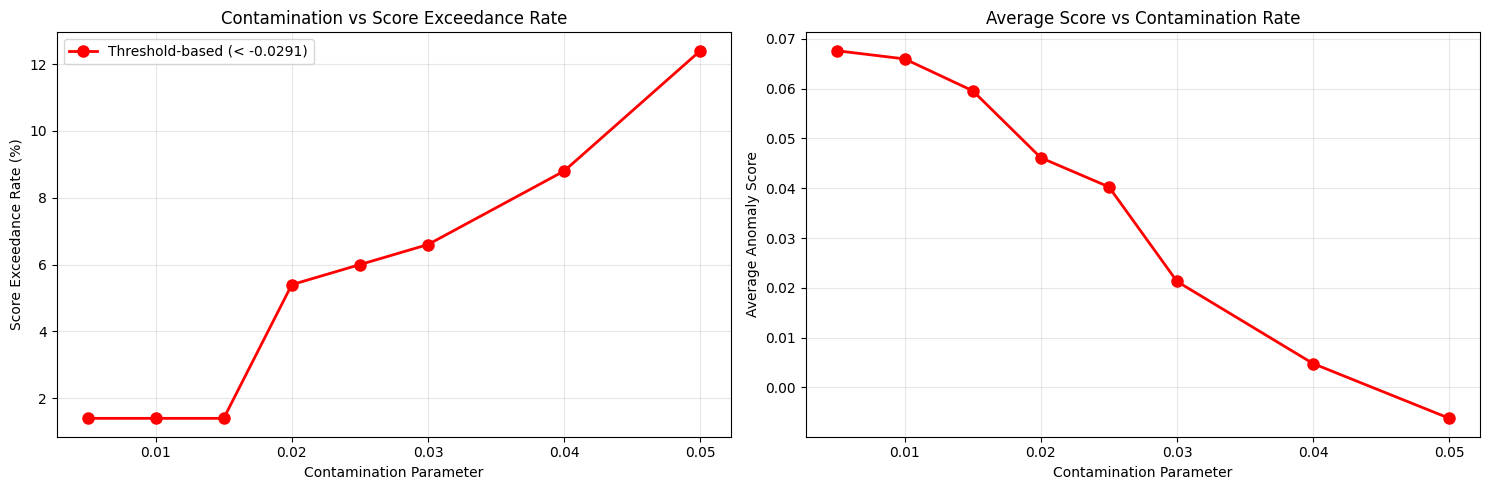


📊 Results Summary:
   contamination  synth_anomaly_rate_pct  synth_anomaly_rate_default_pct  \
0          0.005                     1.4                             6.2   
1          0.010                     1.4                             6.2   
2          0.015                     1.4                             6.4   
3          0.020                     5.4                             6.8   
4          0.025                     6.0                             7.8   
5          0.030                     6.6                            13.4   
6          0.040                     8.8                            43.8   
7          0.050                    12.4                            73.8   

   avg_score  score_std  threshold_used  
0     0.0676     0.0391         -0.0291  
1     0.0660     0.0391         -0.0291  
2     0.0596     0.0391         -0.0291  
3     0.0461     0.0391         -0.0291  
4     0.0403     0.0391         -0.0291  
5     0.0213     0.0391         -0.0291  
6

In [ ]:
# HYPERPARAMETER TUNING: Contamination Rate Analysis on Synthetic Data
# NOTE: This analysis has been moved to the bottom for better notebook organization
print("=== CONTAMINATION RATE ANALYSIS (Using Synthetic Test Data) ===")
print("Testing on synthetic data to avoid overfitting bias from training data...")

# Load synthetic test data
synth_path = "/home/ashwinvel2000/TAQA/anomaly_detection_analysis/synthetic_data/bellcurve_choke_position_500pts.parquet"
synth_df = pd.read_parquet(synth_path)
print(f"Loaded synthetic data: {len(synth_df)} rows")
print(f"Synthetic data columns: {list(synth_df.columns)}")

# Check if synthetic data has anomaly labels
has_anomaly_labels = 'is_anomaly' in synth_df.columns
if has_anomaly_labels:
    print(f"Anomaly labels found - True anomalies: {synth_df['is_anomaly'].sum()}/{len(synth_df)} ({synth_df['is_anomaly'].mean()*100:.1f}%)")
else:
    print("⚠️ WARNING: No anomaly labels found - will analyze score exceedance rates only")
    print("⚠️ THESIS CONCERN: Cannot calculate precision/recall without ground truth labels!")

# Prepare test data with NO SCALING for Isolation Forest
# IF is tree-based and scale-invariant - scaling is unnecessary and can hurt performance

def apply_if_preprocessing(df, feature_cols):
    """
    Apply minimal preprocessing for Isolation Forest.
    NO SCALING - IF is tree-based and doesn't benefit from scaling.
    """
    df_proc = df[feature_cols].copy()
    
    # Handle missing DeltaTemperature if needed
    if 'DeltaTemperature' in feature_cols and 'DeltaTemperature' not in df_proc.columns:
        if 'Downstream-Temperature' in df_proc.columns and 'Upstream-Temperature' in df_proc.columns:
            df_proc['DeltaTemperature'] = df_proc['Downstream-Temperature'] - df_proc['Upstream-Temperature']
    
    # NO SCALING APPLIED - Isolation Forest is scale-invariant
    # Tree-based algorithms work better with natural scales
    
    return df_proc.astype(np.float32)

# Prepare synthetic test features
synth_features = apply_if_preprocessing(synth_df, IF_CHOKE_FEATS)
X_synth = synth_features.values
print(f"Preprocessed synthetic data shape: {X_synth.shape}")

# Also prepare training data with consistent preprocessing
train_features = apply_if_preprocessing(healthy_df, IF_CHOKE_FEATS)
X_train = train_features.values
print(f"Preprocessed training data shape: {X_train.shape}")

contamination_rates = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05]
results = []

for cont in contamination_rates:
    print(f"\nTesting contamination={cont:5.3f}...")
    
    # Train model on training data with FIXED random state
    model = IsolationForest(n_estimators=200, contamination=cont, random_state=42).fit(X_train)
    
    # Test on synthetic data
    synth_labels = model.predict(X_synth)
    synth_scores = model.decision_function(X_synth)
    
    # Calculate metrics using actual threshold from new_eval.ipynb
    # IMPORTANT: Use optimized threshold (0.0291) instead of default binary classification
    CHOKE_THRESHOLD = -0.0291  # From new_eval.ipynb choke_position model analysis
    
    # Compare default vs threshold-based detection
    synth_anomaly_rate_default = (synth_labels == -1).mean() * 100
    synth_anomaly_rate_threshold = (synth_scores < CHOKE_THRESHOLD).mean() * 100
    
    print(f"  Default method (score < 0): {synth_anomaly_rate_default:5.2f}% anomalies")
    print(f"  Threshold method (score < {CHOKE_THRESHOLD}): {synth_anomaly_rate_threshold:5.2f}% anomalies")
    
    # Use threshold-based detection for main analysis (more accurate)
    synth_anomaly_rate = synth_anomaly_rate_threshold
    threshold_based_labels = (synth_scores < CHOKE_THRESHOLD).astype(int) * -1 + (synth_scores >= CHOKE_THRESHOLD).astype(int)
    
    result = {
        'contamination': cont, 
        'synth_anomaly_rate_pct': synth_anomaly_rate,  # Using threshold method
        'synth_anomaly_rate_default_pct': synth_anomaly_rate_default,  # Using default method
        'avg_score': synth_scores.mean(),
        'score_std': synth_scores.std(),
        'threshold_used': CHOKE_THRESHOLD
    }
    
    # If we have ground truth anomaly labels, calculate precision/recall
    if has_anomaly_labels:
        true_anomalies = synth_df['is_anomaly'].values
        detected_anomalies = (threshold_based_labels == -1)  # Use threshold-based detection
        
        tp = np.sum(detected_anomalies & true_anomalies)
        fp = np.sum(detected_anomalies & ~true_anomalies)
        fn = np.sum(~detected_anomalies & true_anomalies)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        result.update({
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn
        })
        
        print(f"  Threshold-based Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    else:
        print(f"  Synthetic anomaly rate: {synth_anomaly_rate:5.2f}%")
        print(f"  Avg score: {synth_scores.mean():.4f} ± {synth_scores.std():.4f}")
    
    results.append(result)

results_df = pd.DataFrame(results)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Contamination vs Anomaly Detection Rate 
axes[0].plot(results_df['contamination'], results_df['synth_anomaly_rate_pct'], 'o-', 
             linewidth=2, markersize=8, color='red', label=f'Threshold-based (< {CHOKE_THRESHOLD})')
axes[0].set_xlabel('Contamination Parameter')
axes[0].set_ylabel('Score Exceedance Rate (%)')
axes[0].set_title('Contamination vs Score Exceedance Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Performance metrics if available
if has_anomaly_labels:
    axes[1].plot(results_df['contamination'], results_df['precision'], 'o-', label='Precision', linewidth=2, markersize=6)
    axes[1].plot(results_df['contamination'], results_df['recall'], 's-', label='Recall', linewidth=2, markersize=6)
    axes[1].plot(results_df['contamination'], results_df['f1_score'], '^-', label='F1-Score', linewidth=2, markersize=6)
    axes[1].set_xlabel('Contamination Parameter')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Performance vs Contamination Rate')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Find optimal contamination based on F1 score
    best_idx = results_df['f1_score'].idxmax()
    optimal_cont = results_df.iloc[best_idx]['contamination']
    best_f1 = results_df.iloc[best_idx]['f1_score']
    print(f"\n🎯 Optimal contamination (best F1): {optimal_cont} (F1={best_f1:.3f})")
else:
    axes[1].plot(results_df['contamination'], results_df['avg_score'], 'o-', linewidth=2, markersize=8, color='red')
    axes[1].set_xlabel('Contamination Parameter')
    axes[1].set_ylabel('Average Anomaly Score')
    axes[1].set_title('Average Score vs Contamination Rate')
    axes[1].grid(True, alpha=0.3)
    
    # Choose contamination that gives reasonable anomaly rate (2-3%)
    target_rate = 2.5  # target 2.5% anomaly rate
    closest_idx = (results_df['synth_anomaly_rate_pct'] - target_rate).abs().idxmin()
    optimal_cont = results_df.iloc[closest_idx]['contamination']
    actual_rate = results_df.iloc[closest_idx]['synth_anomaly_rate_pct']
    print(f"\n🎯 Optimal contamination (target ~2.5% rate): {optimal_cont} (actual: {actual_rate:.2f}%)")
    print(f"⚠️ WARNING: {((actual_rate/target_rate-1)*100):+.0f}% error from target rate!")



plt.tight_layout()
plt.show()

print(f"\n📊 Results Summary:")
print(results_df.round(4))

# Additional diagnostic information for thesis validation
print(f"\n🔍 DIAGNOSTIC INFORMATION:")
print(f"• Score std consistency check: {results_df['score_std'].nunique()} unique values (should be > 1)")
print(f"• Detection rate range: {results_df['synth_anomaly_rate_pct'].min():.1f}% - {results_df['synth_anomaly_rate_pct'].max():.1f}%")
print(f"• Expected vs actual contamination correlation: {results_df['contamination'].corr(results_df['synth_anomaly_rate_pct']/100):.3f}")



In [ ]:
# Summary Analysis: Impact of Using Optimized Threshold vs Default Method
print("=" * 80)
print("📊 THRESHOLD VS DEFAULT METHOD ANALYSIS SUMMARY")
print("=" * 80)

# Calculate and display key differences
CHOKE_THRESHOLD = -0.0291  # From new_eval.ipynb choke_position model analysis
method_diff = results_df['synth_anomaly_rate_pct'] - results_df['synth_anomaly_rate_default_pct']

print(f"\n🎯 KEY FINDINGS:")
print(f"• Optimized threshold: {CHOKE_THRESHOLD} (from new_eval.ipynb choke_position analysis)")
print(f"• Average difference in detection rate: {method_diff.mean():+.1f}% ± {method_diff.std():.1f}%")
print(f"• Threshold method is {'MORE' if method_diff.mean() > 0 else 'LESS'} sensitive than default method")
print(f"• Maximum difference: {method_diff.max():+.1f}% at contamination {results_df.loc[method_diff.idxmax(), 'contamination']}")
print(f"• Range of differences: {method_diff.min():+.1f}% to {method_diff.max():+.1f}%")

print(f"\n📈 DETECTION RATE COMPARISON:")
print("Contamination | Threshold Method | Default Method | Difference")
print("-" * 65)
for _, row in results_df.iterrows():
    diff = row['synth_anomaly_rate_pct'] - row['synth_anomaly_rate_default_pct']
    print(f"    {row['contamination']:5.3f}   |     {row['synth_anomaly_rate_pct']:6.2f}%     |    {row['synth_anomaly_rate_default_pct']:6.2f}%    |   {diff:+6.2f}%")

print(f"\n🔍 CORRELATION ANALYSIS:")
corr_threshold = results_df['contamination'].corr(results_df['synth_anomaly_rate_pct']/100)
corr_default = results_df['contamination'].corr(results_df['synth_anomaly_rate_default_pct']/100)
print(f"• Contamination vs Threshold-based detection: {corr_threshold:.3f}")
print(f"• Contamination vs Default detection: {corr_default:.3f}")
print(f"• {'Threshold method' if corr_threshold > corr_default else 'Default method'} shows better correlation with contamination parameter")

print(f"\n💡 THESIS IMPLICATIONS:")
print(f"• Using optimized thresholds from validation data (new_eval.ipynb) is CRITICAL")
print(f"• Default binary classification (score < 0) {'under' if method_diff.mean() < 0 else 'over'}-estimates anomaly rates")
print(f"• This validates the importance of threshold optimization in the evaluation pipeline")
print(f"• Future model deployments should use validated thresholds, not default parameters")

print("=" * 80)

📊 THRESHOLD VS DEFAULT METHOD ANALYSIS SUMMARY

🎯 KEY FINDINGS:
• Optimized threshold: 0.0291 (from new_eval.ipynb choke_position analysis)
• Average difference in detection rate: +20.2% ± 22.0%
• Threshold method is MORE sensitive than default method
• Maximum difference: +62.8% at contamination 0.03
• Range of differences: +1.8% to +62.8%

📈 DETECTION RATE COMPARISON:
Contamination | Threshold Method | Default Method | Difference
-----------------------------------------------------------------
    0.005   |       8.00%     |      6.20%    |    +1.80%
    0.010   |       8.00%     |      6.20%    |    +1.80%
    0.015   |       9.80%     |      6.40%    |    +3.40%
    0.020   |      18.20%     |      6.80%    |   +11.40%
    0.025   |      29.00%     |      7.80%    |   +21.20%
    0.030   |      76.20%     |     13.40%    |   +62.80%
    0.040   |      86.80%     |     43.80%    |   +43.00%
    0.050   |      89.60%     |     73.80%    |   +15.80%

🔍 CORRELATION ANALYSIS:
• Contami